# Implementation of the Movie Recommendation System

## Using the following libraries/packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Load .csv files from the dataset & clean them

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
links = pd.read_csv('ml-latest-small/links.csv')

In [3]:
genre_split = (movies['genres'].str.split('|',expand=False))
for x in range(len(genre_split)):
    if type(genre_split[x])==list:
        genre_split[x] = ' '.join(genre_split[x])
movies['genresSep'] = genre_split
movies = movies.drop(columns=['genres'])
movies

,movieId,title,genresSep
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation


## Merge dataframes and remove unnecessary attributes

In [4]:
rated_movies = movies.merge(ratings,on='movieId')
df_movies = rated_movies.merge(links,on='movieId')
df_movies = df_movies.drop(columns=['timestamp','tmdbId'])
df_movies

,movieId,title,genresSep,userId,rating,imdbId
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,4.0,114709
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,5,4.0,114709
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,7,4.5,114709
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,15,2.5,114709
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,17,4.5,114709
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy,184,4.0,5476944
100832,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy,184,3.5,5914996
100833,193585,Flint (2017),Drama,184,3.5,6397426
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation,184,3.5,8391976


## Only include ratings by users who rated 10 or more movies (reliable ratings)

In [5]:
f_b = df_movies.groupby('userId').count()['rating'] >= 10
film_buffs = f_b[f_b].index
filtered_ratings = df_movies[df_movies['userId'].isin(film_buffs)]

## Only include ratings of movies rated 5 or more times (popular movies)

In [6]:
p_m = filtered_ratings.groupby('title').count()['rating'] >= 5
popular_movies = p_m[p_m].index
clean_ratings = filtered_ratings[filtered_ratings['title'].isin(popular_movies)]
clean_ratings.drop_duplicates(ignore_index=True)

,movieId,title,genresSep,userId,rating,imdbId
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,4.0,114709
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,5,4.0,114709
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,7,4.5,114709
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,15,2.5,114709
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,17,4.5,114709
...,...,...,...,...,...,...
90278,187595,Solo: A Star Wars Story (2018),Action Adventure Children Sci-Fi,62,4.0,3778644
90279,187595,Solo: A Star Wars Story (2018),Action Adventure Children Sci-Fi,380,4.0,3778644
90280,187595,Solo: A Star Wars Story (2018),Action Adventure Children Sci-Fi,414,3.5,3778644
90281,187595,Solo: A Star Wars Story (2018),Action Adventure Children Sci-Fi,514,3.0,3778644


## Plotting the dataframe

Text(0, 0.5, 'Rating')

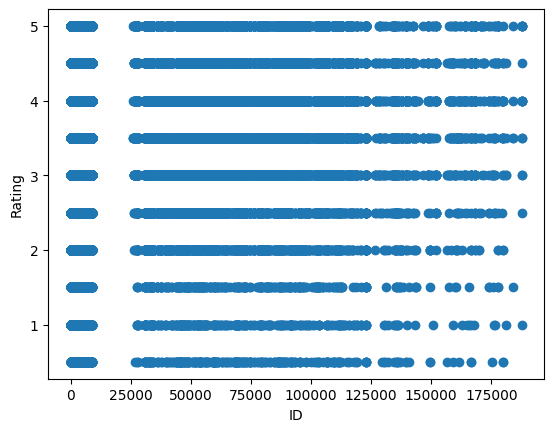

In [7]:
plt.scatter(clean_ratings['movieId'],clean_ratings['rating'])
plt.xlabel('ID')
plt.ylabel('Rating')

## Create a pivot table with userId as columns, title as rows/index and rating as values

In [8]:
pvTable = clean_ratings.pivot_table(index=['title'],columns='userId',values='rating')
pvTable.fillna(0,inplace=True)
pvTable

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
*batteries not included (1987),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Cloverfield Lane (2016),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[REC] (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
eXistenZ (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0
xXx (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,2.0


## Convert the pivot table into a sparse matrix (removing zero/NaN values) for creating model

In [9]:
sparse_mtx = csr_matrix(pvTable)
model = NearestNeighbors(algorithm='auto')

## Train the model by passing it the sparse matrix

In [10]:
model.fit(sparse_mtx)

NearestNeighbors()

## Function for querying the model with movie name (*complete* or *partial*)

In [11]:
def recommend_movie():
    rec = input()
    check = clean_ratings['title'].str.contains(rec,case=False,regex=True)
    idx = check[check].index[0]
    nom = clean_ratings.at[idx,'title']
    mov_id = np.where(pvTable.index == nom)[0][0]
    distances, recommendations = model.kneighbors(pvTable.iloc[mov_id].dropna().values.reshape(1, -1), n_neighbors=5)
    
    for i in range(len(recommendations)):
        for n in range(len(recommendations[i])):
            print(pvTable.index[recommendations[i][n]])

In [12]:
recommend_movie()

 argon


Jason and the Argonauts (1963)
We Bought a Zoo (2011)
SpaceCamp (1986)
Police Academy: Mission to Moscow (1994)
Mr. Popper's Penguins (2011)


## Creating Pickle files for Flask deployment

In [13]:
pickle.dump(clean_ratings,open('clean_ratings.pkl','wb'))
pickle.dump(pvTable,open('pvTable.pkl','wb'))
pickle.dump(model,open('model.pkl','wb'))